In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Explore Images

In [2]:
import os
import matplotlib.pyplot as plt
from PIL import Image

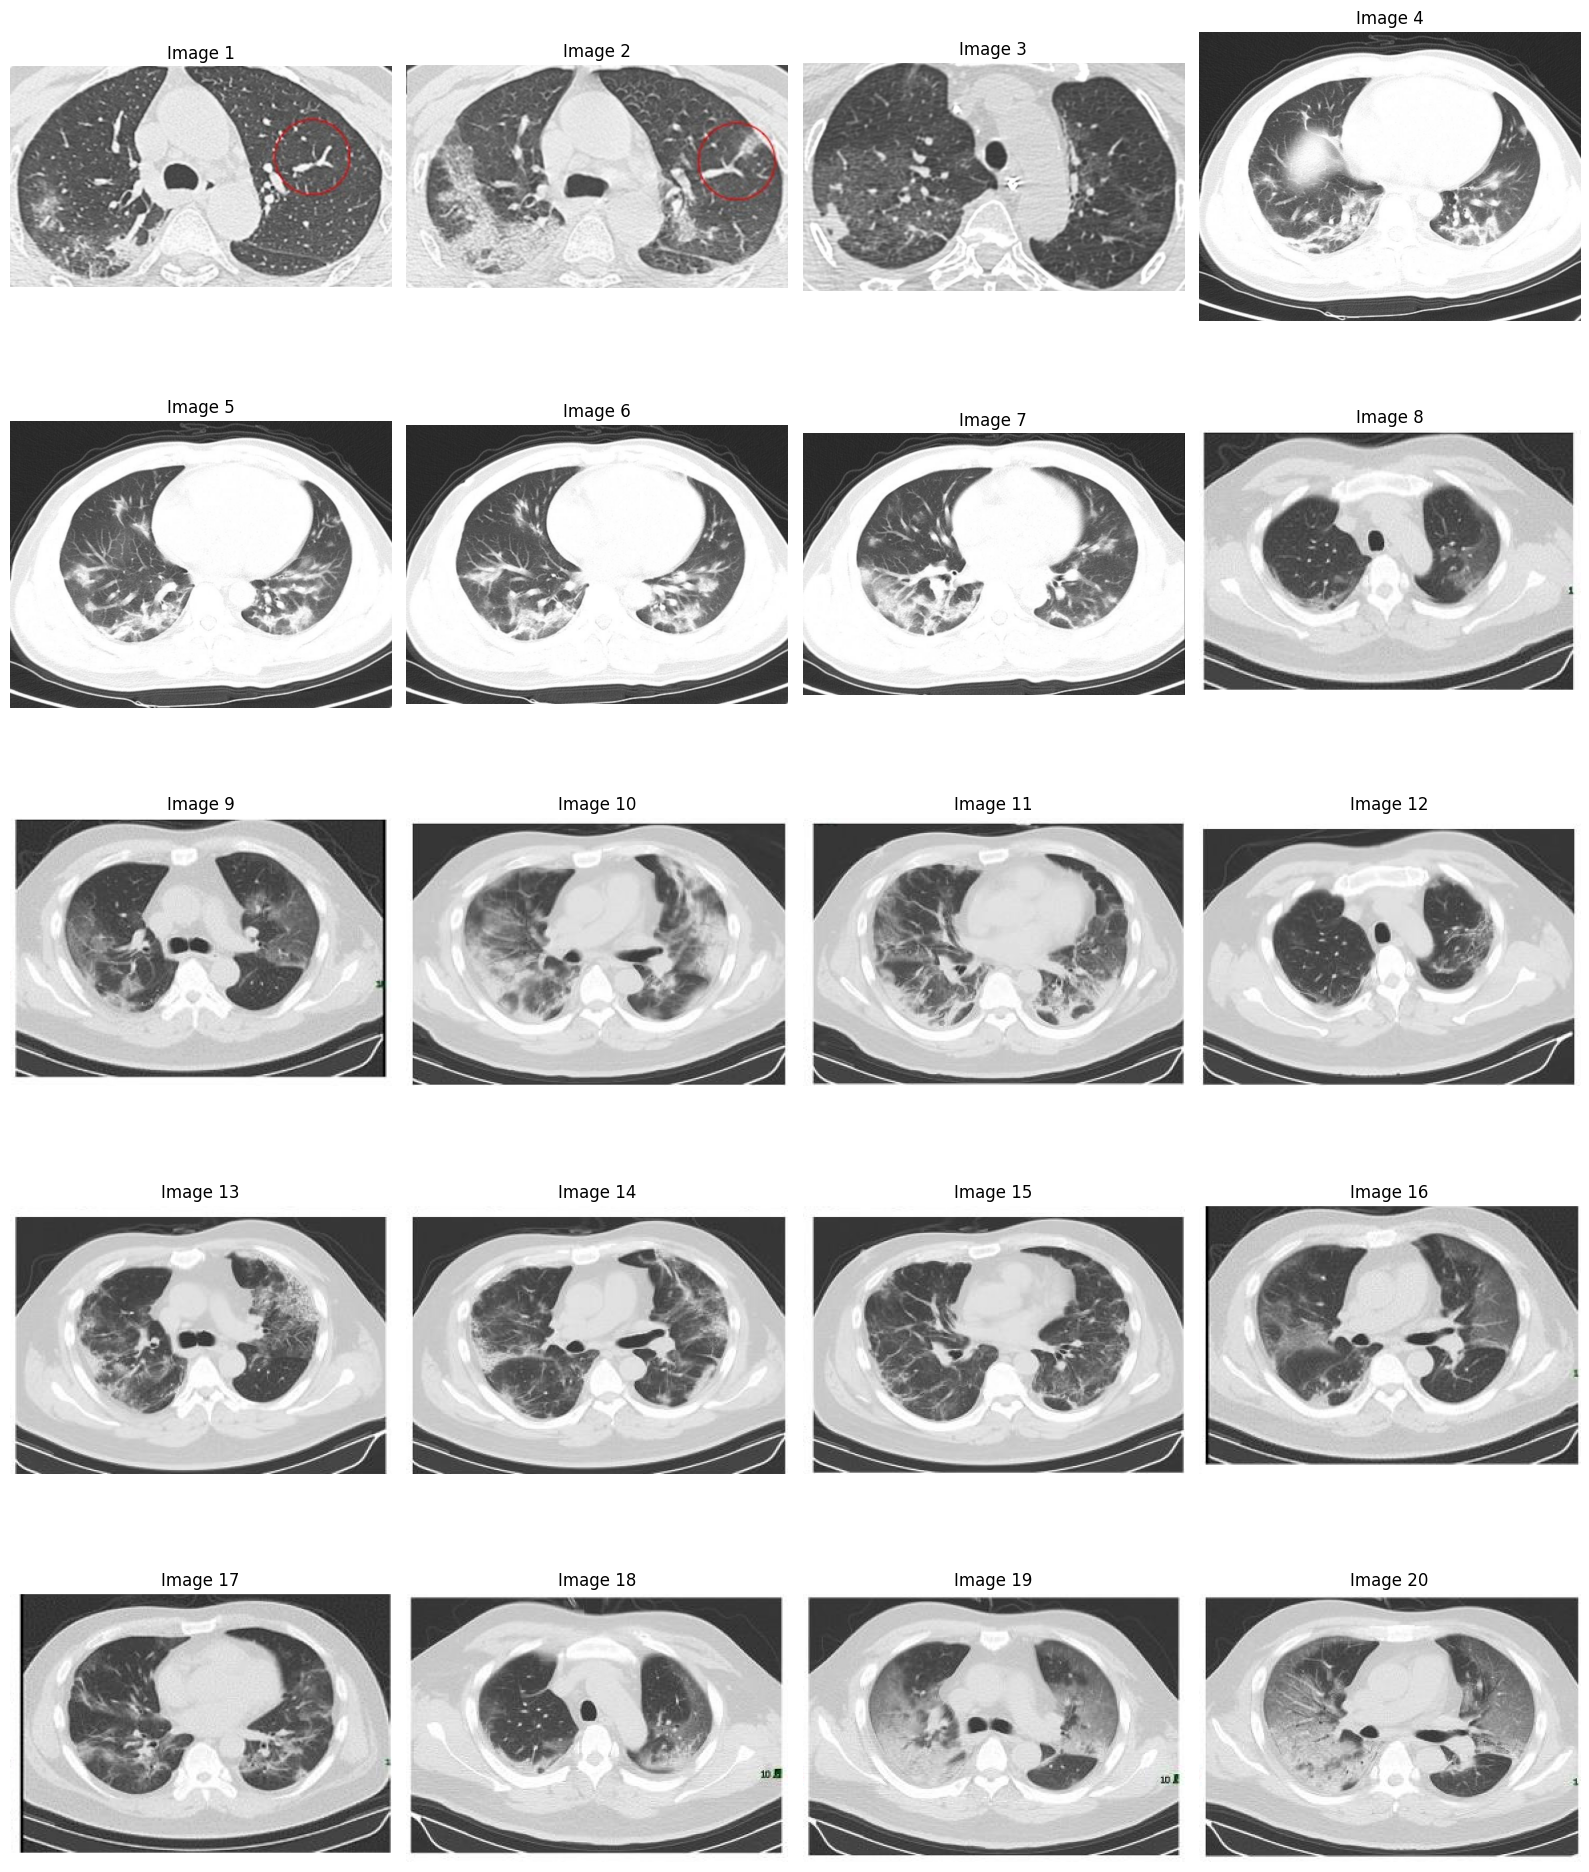

In [3]:
dataset_dir = "/kaggle/input/covidct/CT_COVID"  

# List all image files in the dataset directory
image_files = [f for f in os.listdir(dataset_dir) if f.endswith((".jpg", ".png", ".jpeg"))]

# Define the number of rows and columns for image display
num_rows = 5
num_columns = 4

# Calculate the total number of images to display (num_rows x num_columns)
num_images_to_display = num_rows * num_columns

# Display the selected number of images in a grid
fig, axes = plt.subplots(num_rows, num_columns, figsize=(16, 20))

for i, ax in enumerate(axes.flat):
    # Check if there are more images to display
    if i < num_images_to_display:
        # Load the image using PIL (Python Imaging Library)
        image_path = os.path.join(dataset_dir, image_files[i])
        image = Image.open(image_path)

        # Display the image
        ax.imshow(image)
        ax.axis("off")
        ax.set_title(f"Image {i + 1}")

# Remove any empty subplots if there are fewer than 20 images
for i in range(num_images_to_display, len(axes.flat)):
    fig.delaxes(axes.flat[i])

plt.tight_layout()
plt.show()


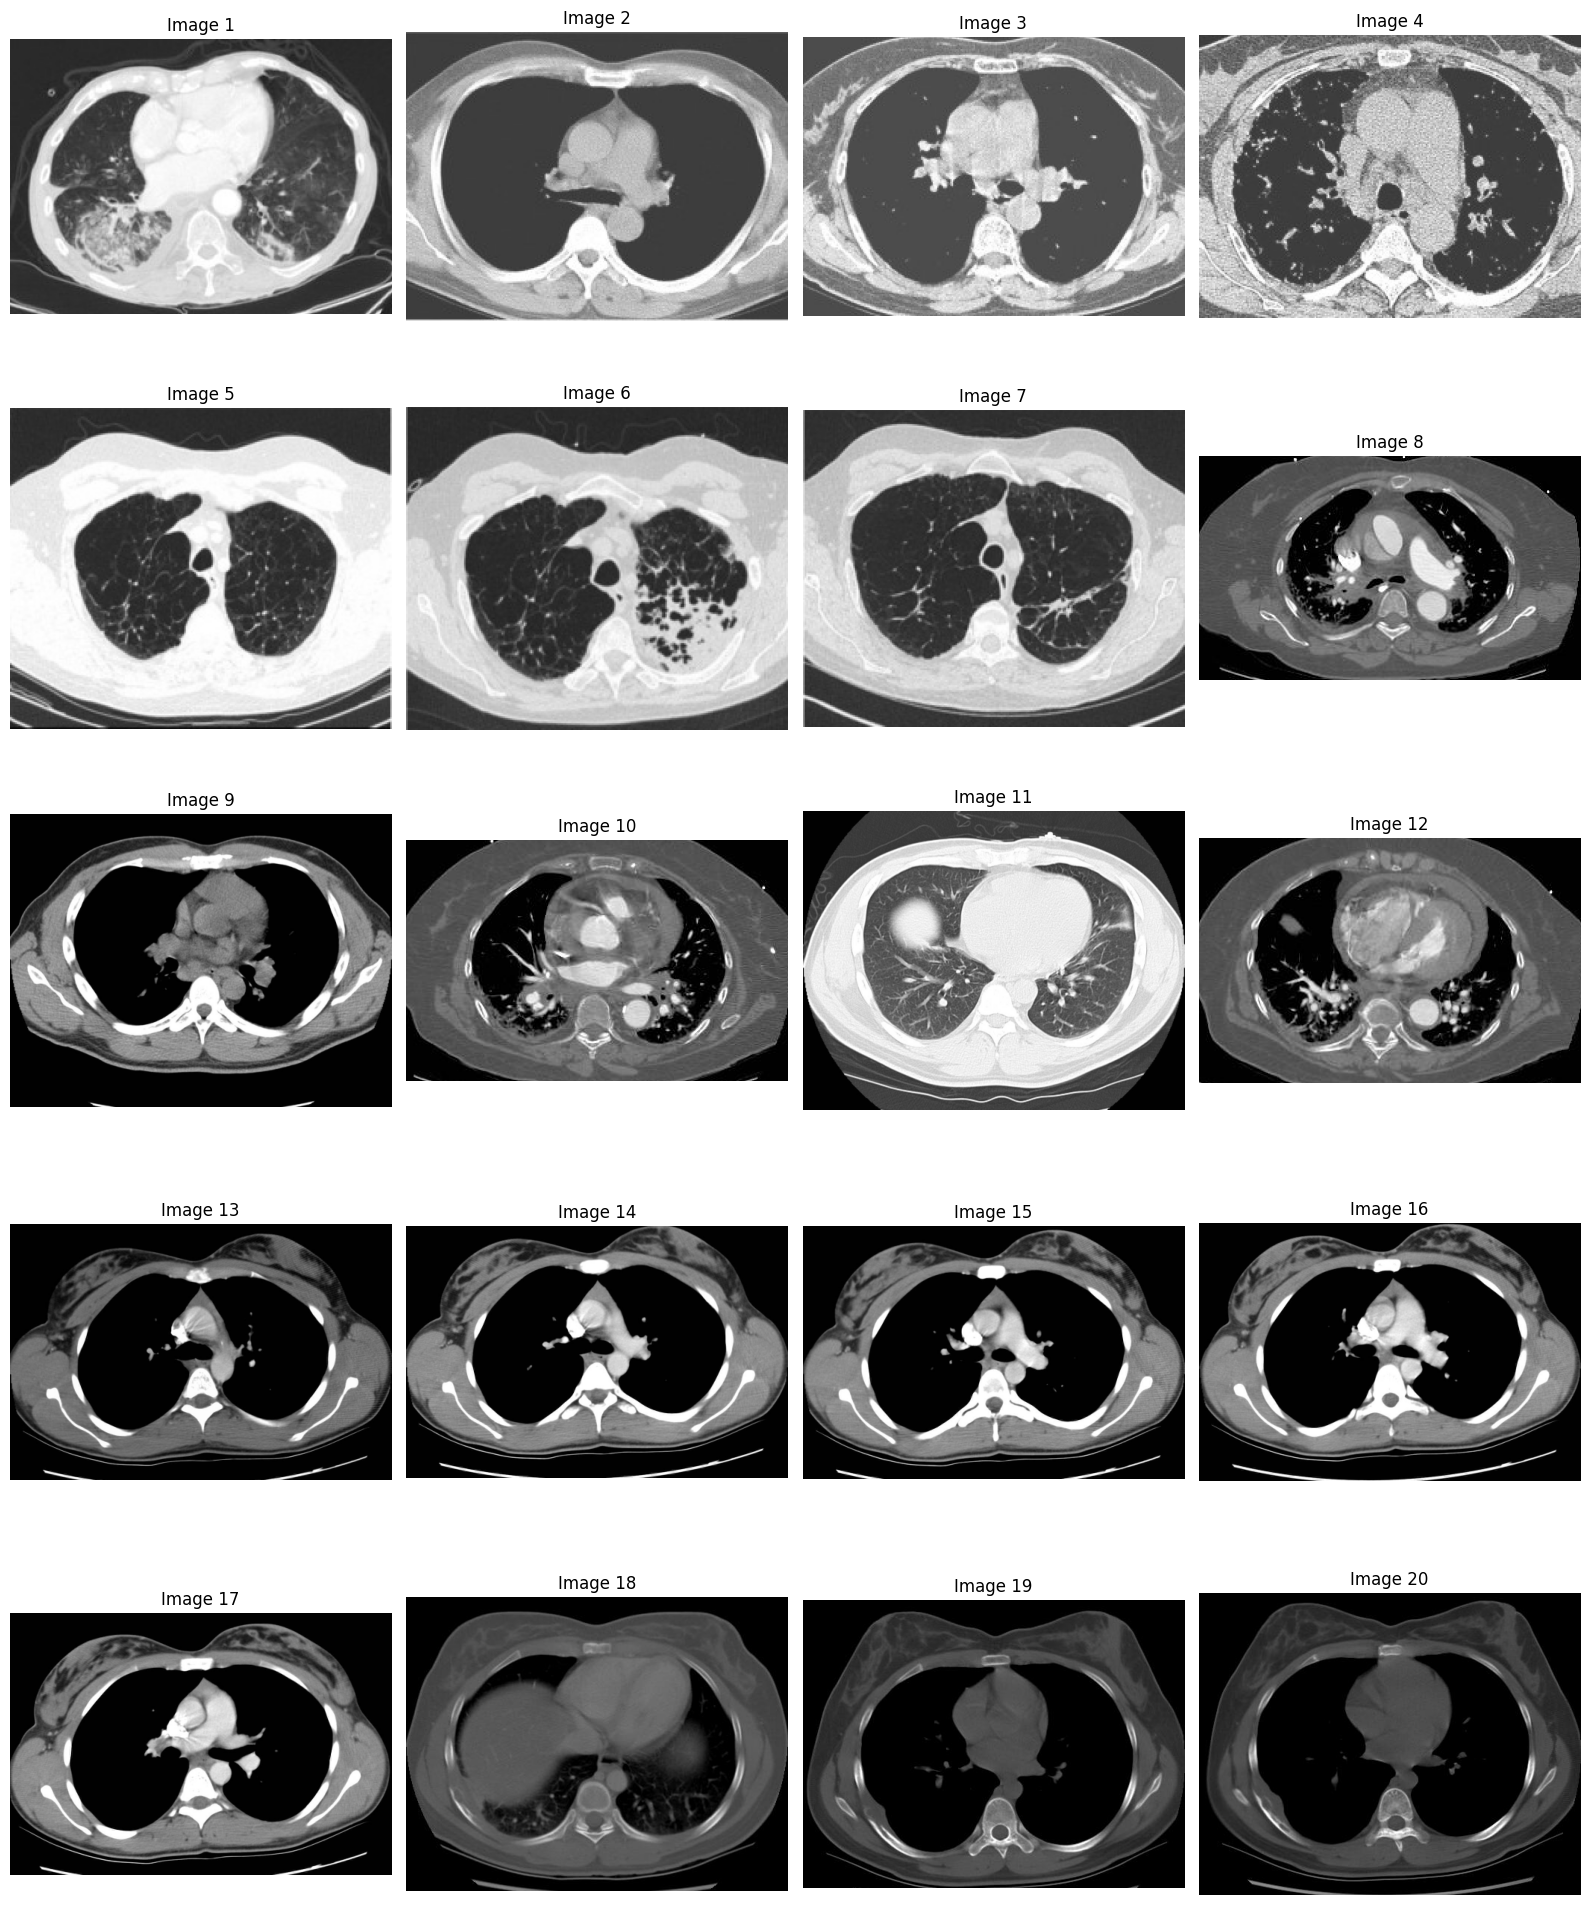

In [4]:
dataset_dir = "/kaggle/input/covidct/CT_NonCOVID"  

# List all image files in the dataset directory
image_files = [f for f in os.listdir(dataset_dir) if f.endswith((".jpg", ".png", ".jpeg"))]

# Define the number of rows and columns for image display
num_rows = 5
num_columns = 4

# Calculate the total number of images to display (num_rows x num_columns)
num_images_to_display = num_rows * num_columns

# Display the selected number of images in a grid
fig, axes = plt.subplots(num_rows, num_columns, figsize=(16, 20))

for i, ax in enumerate(axes.flat):
    # Check if there are more images to display
    if i < num_images_to_display:
        # Load the image using PIL (Python Imaging Library)
        image_path = os.path.join(dataset_dir, image_files[i])
        image = Image.open(image_path)

        # Display the image
        ax.imshow(image)
        ax.axis("off")
        ax.set_title(f"Image {i + 1}")

# Remove any empty subplots if there are fewer than 20 images
for i in range(num_images_to_display, len(axes.flat)):
    fig.delaxes(axes.flat[i])

plt.tight_layout()
plt.show()


# Data Preprocessing:

**Data Splitting:** Split dataset into training, validation, and test sets. 70-80% for training, 10-15% for validation, and 10-15% for testing.

**Data Augmentation:** Apply data augmentation techniques to increase the diversity of training dataset. This helps improve model generalization. Common augmentations include random rotations, flips, zooms, and brightness adjustments.

In [5]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

In [6]:
# Define data transformations for data augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),  # Randomly crop and resize
    transforms.RandomHorizontalFlip(),  # Randomly flip horizontally
    transforms.RandomRotation(10),  # Randomly rotate by up to 10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Adjust color
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

In [7]:
# Define validation and test transformations (usually no augmentation)
val_test_transform = transforms.Compose([
    transforms.Resize(256),  # Resize to a fixed size for validation/testing
    transforms.CenterCrop(224),  # Crop the center for validation/testing
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [8]:
dataset = ImageFolder(root='/kaggle/input/covidct', transform=train_transform)

# Define the sizes for train, validation, and test splits
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split the dataset into train, validation, and test sets
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

In [9]:
# Create data loaders
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size)
test_loader = DataLoader(test_set, batch_size=batch_size)

In [10]:
# configure device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.metrics import precision_score, recall_score, f1_score

# Define your custom CNN model
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(256 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 2)  # 2 classes: COVID-19 and non-COVID-19

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 256 * 28 * 28)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define hyperparameters
learning_rate = 0.001
num_epochs = 10

# Create an instance of your custom CNN
model = CustomCNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop (you can use the train_loader you defined earlier)
total_batches = len(train_loader)
for epoch in range(num_epochs):
    for batch_idx, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print progress
        print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{total_batches}], Loss: {loss.item():.4f}")

# Rest of the code remains the same


# Evaluation loop (you can use the val_loader for evaluation)
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.tolist())
        all_labels.extend(labels.tolist())

# Calculate evaluation metrics
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Epoch [1/10], Batch [1/19], Loss: 0.7022
Epoch [1/10], Batch [2/19], Loss: 32.2837
Epoch [1/10], Batch [3/19], Loss: 3.4523
Epoch [1/10], Batch [4/19], Loss: 1.3328
Epoch [1/10], Batch [5/19], Loss: 0.7062
Epoch [1/10], Batch [6/19], Loss: 0.7876
Epoch [1/10], Batch [7/19], Loss: 0.7186
Epoch [1/10], Batch [8/19], Loss: 0.6993
Epoch [1/10], Batch [9/19], Loss: 0.7113
Epoch [1/10], Batch [10/19], Loss: 0.6546
Epoch [1/10], Batch [11/19], Loss: 0.7469
Epoch [1/10], Batch [12/19], Loss: 0.6704
Epoch [1/10], Batch [13/19], Loss: 0.7082
Epoch [1/10], Batch [14/19], Loss: 0.6918
Epoch [1/10], Batch [15/19], Loss: 0.6916
Epoch [1/10], Batch [16/19], Loss: 0.6928
Epoch [1/10], Batch [17/19], Loss: 0.6940
Epoch [1/10], Batch [18/19], Loss: 0.6923
Epoch [1/10], Batch [19/19], Loss: 0.6948
Epoch [2/10], Batch [1/19], Loss: 0.6919
Epoch [2/10], Batch [2/19], Loss: 0.6905
Epoch [2/10], Batch [3/19], Loss: 0.6928
Epoch [2/10], Batch [4/19], Loss: 0.6896
Epoch [2/10], Batch [5/19], Loss: 0.6848
Epoch

**RESNET** 

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from PIL import Image
import os
import matplotlib.pyplot as plt

# Data transformations
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the dataset
dataset = ImageFolder(root='/kaggle/input/covidct', transform=train_transform)


class CustomResNet(nn.Module):
    def __init__(self):
        super(CustomResNet, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, 2)

    def forward(self, x):
        return self.resnet(x)

# Define hyperparameters
learning_rate = 0.1
num_epochs = 10
batch_size = 32


kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

average_precision = 0
average_recall = 0
average_f1 = 0

for fold, (train_indices, val_indices) in enumerate(kf.split(dataset, dataset.targets)):
    train_set = torch.utils.data.Subset(dataset, train_indices)
    val_set = torch.utils.data.Subset(dataset, val_indices)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size)


    model = CustomResNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Implement early stopping
    best_val_loss = float('inf')
    patience = 3
    no_improvement = 0

    for epoch in range(num_epochs):
        for batch_idx, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                val_loss += criterion(outputs, labels)
        
        val_loss /= len(val_loader)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improvement = 0
            # Save the best model checkpoint
            torch.save(model.state_dict(), f"fold_{fold}_best_model.pth")
        else:
            no_improvement += 1
            if no_improvement >= patience:
                print(f"Early stopping after {epoch+1} epochs.")
                break

    # Evaluate on the validation set
    model.load_state_dict(torch.load(f"fold_{fold}_best_model.pth"))
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.tolist())
            all_labels.extend(labels.tolist())


    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print(f"Fold {fold+1} - Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

    average_precision += precision
    average_recall += recall
    average_f1 += f1

# Calculate average precision, recall, and F1 scores across all folds
average_precision /= 5
average_recall /= 5
average_f1 /= 5'


print(f"Average Precision: {average_precision:.4f}")
print(f"Average Recall: {average_recall:.4f}")
print(f"Average F1 Score: {average_f1:.4f}")


c:\Users\KOBINATH\.conda\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\KOBINATH\.conda\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold 1 - Precision: 0.5333, Recall: 1.0000, F1 Score: 0.6957


c:\Users\KOBINATH\.conda\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\KOBINATH\.conda\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Early stopping after 6 epochs.
Fold 2 - Precision: 0.5302, Recall: 1.0000, F1 Score: 0.6930


c:\Users\KOBINATH\.conda\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\KOBINATH\.conda\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold 3 - Precision: 0.6207, Recall: 0.2278, F1 Score: 0.3333


c:\Users\KOBINATH\.conda\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\KOBINATH\.conda\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold 4 - Precision: 0.5302, Recall: 1.0000, F1 Score: 0.6930


c:\Users\KOBINATH\.conda\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\KOBINATH\.conda\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold 5 - Precision: 0.5369, Recall: 1.0000, F1 Score: 0.6987
Average Precision: 0.5503
Average Recall: 0.8456
Average F1 Score: 0.6227
